# Quant Course: Lecture 6




## Option Pricing by PDE

<b>Goal of option pricing via PDE:<b>

* Use the Black Scholes PDE to price European Contract
* Use  different discretization scheme to achieve better results
* Compare the solution to the Analytical Pricer


<b>Extension<b>
* Calculate Greeks based on the different Schemes
* Extend PDE pricing scheme to Forward and American contracts<b>

# Steps to achieve our Objectives
* Create Market Model
* Create European Contract using market inputs (underlying, Call/Put, Long/Short, strike, expiry)
* Create PDEParams using $dS, dt, S_{min}, S_{max} $ and method (implicit, explicit, CrankNicolson) as inputs
* Create EuropeanPDEPricer using the contract, model and PDEParams
* Calculate FV
* Visualize the Call and Put prices in 2D and 3D

In [1]:
# Add current folder and QuantCourseBP folder to syspath to import modules
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

current = Path(Path().resolve())
sys.path.append(str(current))
sys.path.append(str(current.parents[1]))

from src.enums import *
from src.utils import *
from src.market_data import *
from src.pricer import *
# Make charts interactive
%matplotlib notebook

# Initialize market data
MarketData.initialize()

# Utility function

In [2]:
"""The pricing function of European call option"""
def black_scholes_eur_call(spot, time_to_mat,sigma, strike, rate):
    d1_vec = ( np.log( spot / strike ) + ( rate + 0.5 * sigma**2 ) * time_to_mat ) / ( sigma * time_to_mat**0.5 )
    d2_vec = d1_vec - sigma * time_to_mat**0.5

    N_d1_vec = norm.cdf(d1_vec)
    N_d2_vec = norm.cdf(d2_vec)

    return N_d1_vec * spot - strike * np.exp((-1.0)*rate*time_to_mat) * N_d2_vec

# Create Test Example Contracts

In [3]:
und = Stock.TEST_COMPANY
expiry = 2.0
strike = 0.95 * MarketData.get_spot()[und]
ls = LongShort.LONG

In [4]:
derivative_type = [PutCallFwd.CALL, PutCallFwd.CALL,PutCallFwd.PUT,PutCallFwd.PUT]
model_types = [BSVolModel(und), FlatVolModel(und), BSVolModel(und), FlatVolModel(und)]

contract_list=[]
analytical_pricer_list= []
for i in range(len(derivative_type)):
    contract = EuropeanContract(und, derivative_type[i], ls, strike, expiry)
    contract_list.append(contract)
    pricer = EuropeanAnalyticPricer(contract, model_types[i], Params())
    analytical_pricer_list.append(pricer.calc_fair_value())

print(f"FairValues:{analytical_pricer_list}")

FairValues:[23.60627624868423, 19.558965822125977, 9.565830962100371, 5.518520535542123]


<img src="lesson_pages/1.png">

<img src="lesson_pages/2.png">

<img src="lesson_pages/3.png">

<img src="lesson_pages/4.png">

<img src="lesson_pages/5.png">

# Example with Explicit Method

* Create European Contract
* Create Market Model
* Create PDEParams
* Create GenericPDEPricer
* Calculate FV and Greeks based on Explicit method
* Visualize the Call and Put prices in 2D and 3D

In [5]:
params_exp = PDEParams(method = "explicit")
PDE_price_exp = []
PDE_pricers_exp=[]
for i in range(len(derivative_type)): 
    PDEpricer = EuropeanPDEPricer(contract_list[i], model_types[i], params_exp)
    fv = PDEpricer.calc_fair_value()
    PDE_pricers_exp.append(PDEpricer)
    PDE_price_exp.append(fv)



In [6]:
print(f"PDE Explicit method FairValues:{PDE_price_exp}")
print(f"Analytical method FairValues:{analytical_pricer_list}")

PDE Explicit method FairValues:[23.604447307816308, 19.559315913934707, 9.563828924282564, 5.518692809208318]
Analytical method FairValues:[23.60627624868423, 19.558965822125977, 9.565830962100371, 5.518520535542123]


In [7]:
Errors = [price1-price2 for price1, price2 in zip(analytical_pricer_list,PDE_price_exp)]
print(f"Error between the Analytical and PDE Explicit method FairValues:{Errors}")

Error between the Analytical and PDE Explicit method FairValues:[0.001828940867923734, -0.0003500918087304683, 0.0020020378178067233, -0.00017227366619465556]


In [8]:
und_step = PDE_pricers_exp[0].und_step
time_step = PDE_pricers_exp[0].time_step
s_min= PDE_pricers_exp[0].stock_min
s_max=PDE_pricers_exp[0].stock_max
sigma = PDE_pricers_exp[0]._bsPDE.sigma
spot = PDE_pricers_exp[0]._initial_spot
rate = PDE_pricers_exp[0]._bsPDE.interest_rate
num_of_und_steps = PDE_pricers_exp[0]._bsPDE.num_of_und_steps

C:\Users\User\AppData\Local\Temp\ipykernel_11568\1498780719.py:3: RuntimeWarning: divide by zero encountered in log
  d1_vec = ( np.log( spot / strike ) + ( rate + 0.5 * sigma**2 ) * time_to_mat ) / ( sigma * time_to_mat**0.5 )


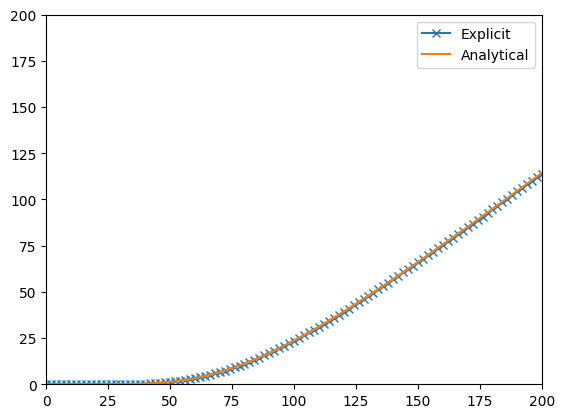

In [9]:
import matplotlib.pyplot as plt
sol_exp = PDE_pricers_exp[0].grid[0,:]
Spots = np.linspace(s_min, s_max, num_of_und_steps+1)

%matplotlib inline
plt.plot(Spots, sol_exp, "x-", label="Explicit")
plt.plot(Spots, black_scholes_eur_call(Spots, expiry, sigma, strike, rate), label="Analytical")

plt.xlim(0, s_max)
plt.ylim(0,s_max)
plt.legend()
plt.show()

# Implicit Method

<img src="lesson_pages/6.png">

<img src="lesson_pages/7.png">

<img src="lesson_pages/7.png">

<img src="lesson_pages/8.png">

# Example with Implicit Method

* Create European Contract
* Create Market Model
* Create PDEParams
* Create GenericPDEPricer
* Calculate FV and Greeks based on Implicit method
* Visualize the Call and Put prices in 2D and 3D

In [10]:
param_imp = PDEParams(method = "implicit")
PDE_imp_price = []
PDEpricers_imp = []
for i in range(len(derivative_type)): 
    PDEpricer = EuropeanPDEPricer(contract_list[i], model_types[i], param_imp)
    fv = PDEpricer.calc_fair_value()
    PDE_imp_price.append(fv)
    PDEpricers_imp.append(PDEpricer)

In [11]:
print(f"PDE Implicit method FairValues:{PDE_imp_price}")
print(f"Analytical method FairValues:{analytical_pricer_list}")

PDE Implicit method FairValues:[23.60198913553196, 19.557755216197634, 9.562097627250461, 5.5176052392037995]
Analytical method FairValues:[23.60627624868423, 19.558965822125977, 9.565830962100371, 5.518520535542123]


In [12]:
Errors_imp = [price1-price2 for price1, price2 in zip(analytical_pricer_list,PDE_imp_price)]
print(f"Error between the Analytical and PDE Explicit method FairValues:{Errors_imp}")

Error between the Analytical and PDE Explicit method FairValues:[0.004287113152273037, 0.0012106059283425452, 0.0037333348499100083, 0.0009152963383236568]


C:\Users\User\AppData\Local\Temp\ipykernel_11568\1498780719.py:3: RuntimeWarning: divide by zero encountered in log
  d1_vec = ( np.log( spot / strike ) + ( rate + 0.5 * sigma**2 ) * time_to_mat ) / ( sigma * time_to_mat**0.5 )


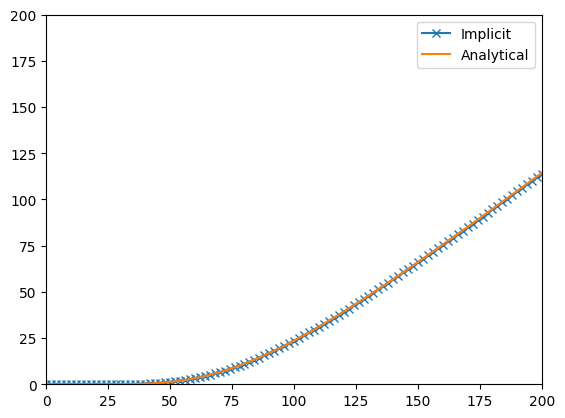

In [13]:
#Implement 
sol_imp = PDEpricers_imp[0].grid[0,:]


%matplotlib inline
plt.plot(Spots, sol_imp, "x-", label="Implicit")
plt.plot(Spots, black_scholes_eur_call(Spots, expiry, sigma, strike, rate), label="Analytical")

plt.xlim(0, s_max)
plt.ylim(0,s_max)
plt.legend()
plt.show()

<img src="lesson_pages/9.png">

<img src="lesson_pages/10.png">

<img src="lesson_pages/11.png">

# Example with Crank Nicolson Method

* Create European Contract
* Create Market Model
* Create PDEParams
* Create GenericPDEPricer
* Calculate FV and Greeks based on Crank_Nicolson methods
* Visualize the Call and Put prices in 2D and 3D

In [14]:
param_crn = PDEParams(method = "cranknicolson")
PDE_crn_price = []
PDEPricers_crn =[]
for i in range(len(derivative_type)): 
    PDEpricer = EuropeanPDEPricer(contract_list[i], model_types[i], param_crn)
    fv = PDEpricer.calc_fair_value()
    PDE_crn_price.append(fv)
    PDEPricers_crn.append(PDEpricer)

In [15]:
print(f"PDE Crank-Nicolson method FairValues:{PDE_crn_price}")
print(f"Analytical method FairValues:{analytical_pricer_list}")

PDE Crank-Nicolson method FairValues:[23.6034086340357, 19.558594355475716, 9.562963346249866, 5.518149067657358]
Analytical method FairValues:[23.60627624868423, 19.558965822125977, 9.565830962100371, 5.518520535542123]


In [16]:
Errors_crn = [price1-price2 for price1, price2 in zip(analytical_pricer_list,PDE_crn_price)]
print(f"Error between the Analytical and PDE Crank Nicolson method FairValues:{Errors_crn}")

Error between the Analytical and PDE Crank Nicolson method FairValues:[0.0028676146485331344, 0.0003714666502609987, 0.00286761585050499, 0.0003714678847650532]


C:\Users\User\AppData\Local\Temp\ipykernel_11568\1498780719.py:3: RuntimeWarning: divide by zero encountered in log
  d1_vec = ( np.log( spot / strike ) + ( rate + 0.5 * sigma**2 ) * time_to_mat ) / ( sigma * time_to_mat**0.5 )


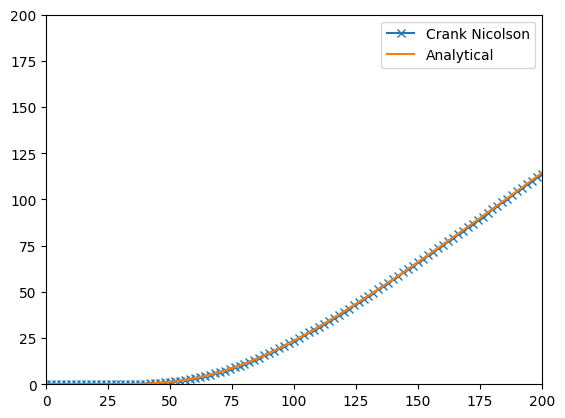

In [17]:
#Implement 
sol_imp = PDEPricers_crn[0].grid[0,:]

%matplotlib inline
plt.plot(Spots, sol_imp, "x-", label="Crank Nicolson")
plt.plot(Spots, black_scholes_eur_call(Spots, expiry, sigma, strike, rate), label="Analytical")

plt.xlim(0, s_max)
plt.ylim(0,s_max)
plt.legend()
plt.show()

# Conclusion

* We have seen the implemention of European Call/Put options pricing via PDE methods
* Which method is faster?

<b> Project Ideas <b>

* Implement Forward pricing on the Grid
* Complexity: Can you price American Option with this?